To start, remake my "sim-env" environment with 

```conda env create -f environment.yml```

# Goal: Investigate the conformation of common LC - cores
We will compare the conformation of a diphenyl fragment, which is commonly used in liquid crystal systems. 

This lesson will teach: 

1. Default SMIRNOFF parameterization
2. Foyer parameterization with OPLS 
3. ASE with XTB calculator 

The goal will be to compare the dihedral potential of the ```[#6X3;r6:1]:[#6D3;r6:2]-[#6D3;r6:3]:[#6X3;r6:4]``` by doing a torsional scan using 
openff (Sage in openmm), foyer (opls), and xtb across LC cores with different substituents.


## Systems to investigate:



SMILES strings:
- A: C1(C2=CC=CC=C2)=CC=CC=C1
- B: CC1=C(C2=CC=CC=C2)C=CC=C1 
- C: CC1=C(C2=CC=CC=C2)C(C)=CC=C1

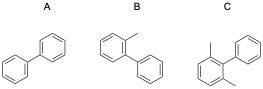

First, lets visualize the dihedral we're going to scan across.

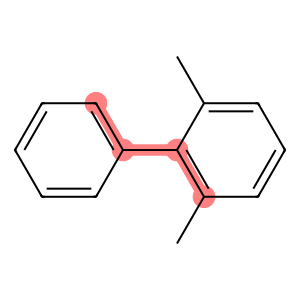

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

smi = "CC1=C(C2=CC=CC=C2)C(C)=CC=C1"
dih_smarts = "[#6X3;r6:1]:[#6D3;r6:2]-[#6D3;r6:3]:[#6X3;r6:4]"
pat = Chem.MolFromSmarts(dih_smarts)

# Build with Hs (to satisfy RDKit’s warning), then drop them for a clean 2D draw
mol = Chem.MolFromSmiles(smi)
mol_h = Chem.AddHs(mol)
mol_2d = Chem.RemoveHs(mol_h)
AllChem.Compute2DCoords(mol_2d)

match = mol_2d.GetSubstructMatch(pat)   # no 'uniquify' here
if not match:
    raise RuntimeError("SMARTS did not match.")

highlight_atoms = list(match)
highlight_bonds = [
    mol_2d.GetBondBetweenAtoms(match[i], match[i+1]).GetIdx()
    for i in range(len(match)-1)
]

img = Draw.MolToImage(
    mol_2d,
    size=(300, 300),
    highlightAtoms=highlight_atoms,
    highlightBonds=highlight_bonds
)
img  


Ok, this looks good. Let's start by parameterizing the molecule using openff.
The general layout of OpenFF's software is: 

![workflow](images/openff_workflow.png)

Documentation: https://docs.openforcefield.org/projects/interchange/en/stable/index.html You need both a topology and forcefield to make an interchange object.

In [2]:
from pathlib import Path
import numpy as np
from openff.toolkit import Molecule, ForceField
from openff.toolkit.utils import ToolkitRegistry
from espaloma_charge.openff_wrapper import EspalomaChargeToolkitWrapper
from openff.interchange import Interchange
from openff.units import unit

# --- inputs ---
ff_path = Path("forcefields/openff_unconstrained-2.2.1.offxml")

# 1) Molecule + coords
biphenyl = Molecule.from_smiles(smi,allow_undefined_stereo=True)
biphenyl.generate_conformers(n_conformers=1)

# 2) Espaloma charges (no RDKit wrapper needed)
toolkits = ToolkitRegistry([EspalomaChargeToolkitWrapper()])
biphenyl.assign_partial_charges("espaloma-am1bcc", toolkit_registry=toolkits)

# 3) Force field and Interchange
ff = ForceField(str(ff_path))
#add 5nm box vectors and pbcs to topology
L= 5
top = biphenyl.to_topology()
top.box_vectors = unit.Quantity(
    [[L, 0, 0],
     [0, L, 0],
     [0, 0, L]],
    unit.nanometer
)
interchange = Interchange.from_smirnoff(force_field=ff, topology=top)
pos = biphenyl.conformers[0].to(unit.nanometer)   # (n_atoms, 3)
pos -= pos.mean(axis=0)                           # center at origin
half_box = top.box_vectors.to(unit.nanometer).diagonal()/2
pos += half_box                                   # shift to box center
interchange.positions = pos



# 4) Save to GROMACS as example
interchange.to_gromacs("molecule")




/Users/jv6139/miniforge3/envs/sim-env/lib/python3.12/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name '' and SMILES '[H][c]1[c]([H])[c]([H])[c](-[c]2[c]([C]([H])([H])[H])[c]([H])[c]([H])[c]([H])[c]2[C]([H])([H])[H])[c]([H])[c]1[H]'' has 1 conformers, but charge method 'espaloma-am1bcc' expects exactly 0.
  self._check_n_conformers(
/Users/jv6139/miniforge3/envs/sim-env/lib/python3.12/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[23:14:34] DEPRECATION WARNING: please use GetValence(which=)
[23:14:34] DEPRECATION WARNING: please use GetValence(which=)
[23:14:34] DEPRECATION WARNING: please use GetValence(which=)
[23:14:34] DEPRECATION WARNING: please use GetValence(which=)
[23:14:34] DEPRECATION WARNING: please use GetValence(which=)
[23:14:34] DEPRECATION WARNING: please use GetValence(which=)
[23:14:34] DEPRECATION WARNING: p

Ok, now that we have a parameterized file lets use a premade workflow I have programmed into helpers.py which will do a torsional scan over the relevant dihedral.

Dihedral scan: 100%|██████████| 37/37 [00:22<00:00,  1.67it/s]


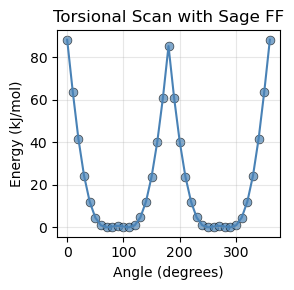

In [3]:
from helpers import scan_dihedral_openmm  # not scan_dihedral_gromacs
df_sage = scan_dihedral_openmm(
    interchange=interchange,
    dih_smarts = "[#6X3;r6:1]:[#6D3;r6:2]-[#6D3;r6:3]:[#6X3;r6:4]",
    angles_deg=range(0, 361, 10),   # or list(...)
    k_restraint=10000.0,             # kJ/mol/rad^2 (default OK)
)

import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
# Plot the line
plt.plot(df_sage["angle"], df_sage["energy_kJ_mol"]-df_sage["energy_kJ_mol"].min(), color="#4982B6", linestyle='-',label="Sage FF")
# Add scatter points on top
plt.scatter(df_sage["angle"], df_sage["energy_kJ_mol"]-df_sage["energy_kJ_mol"].min(), color="#4982B6", s=40, edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Angle (degrees)")
plt.ylabel("Energy (kJ/mol)")
plt.title("Torsional Scan with Sage FF")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Now let’s compare with OPLS-AA. We need to parameterize first, and I’m going to use Foyer for that. OpenFF Interchange can ingest Foyer force fields, so we can stash all our rules and parameters there. There are other ways to assign atom types, and you can also do it manually for atoms you think may be missing assignment but I haven't played around with that too much.

I dug up a partially converted database, so we’ll use that. Public repos sometimes throw FF validation warnings—missing citations, missing SMARTS on some atom types, etc. Foyer actually ships with a built-in OPLS-AA force field, but for the demo I’m sticking with the random one I found on GitHub. Not all atom types have SMARTS assignments, so we could finish the conversion ourselves—it’s basically “add things as you discover them.”

Foyer can also hold coarse-grained force fields. I’m less clear on the details, but it seems roughly analogous to gendata: you define the mapping and parameters and let Foyer handle the bookkeeping.

Foyer documentation can be found here: https://foyer.mosdef.org/en/stable/topic_guides/parameter_definitions.html

Currently it only supports a handful of functional forms--but we could fork the github repo and add our own depending on our use cases.


In [4]:
import foyer


# --- inputs ---
L = 5.0  # nm box length


# 1) Foyer force field
ff_opls = foyer.Forcefield("forcefields/oplsaa.xml")


# 2) OFF molecule + conformer
biphenyl_foyer = Molecule.from_smiles(smi, allow_undefined_stereo=True)
if not biphenyl_foyer.conformers:
    biphenyl_foyer.generate_conformers(n_conformers=1)

# 3) OFF topology with box
top = biphenyl_foyer.to_topology()
top.box_vectors = unit.Quantity([[L, 0, 0],
                                 [0, L, 0],
                                 [0, 0, L]], unit.nanometer)

# 4) Interchange from Foyer
interchange_opls = Interchange.from_foyer(topology=top, force_field=ff_opls)
interchange["vdW"].mixing_rule = "geometric" #source: helpful developers!


# 5) Positions → center in box
pos = biphenyl_foyer.conformers[0].to(unit.nanometer)
pos -= pos.mean(axis=0)
half_box = top.box_vectors.to(unit.nanometer).diagonal() / 2
pos += half_box
interchange_opls.positions = pos

# 6) List atom ↔ OPLS type (from vdW collection)
def list_atom_types(inter):
    for nm in ("vdW", "vdw", "Nonbonded"):
        if nm in inter.collections:
            coll = inter.collections[nm]
            break
    else:
        raise KeyError("No vdW/Nonbonded collection found in Interchange.")
    rows = []
    for tkey, pkey in coll.key_map.items():
        idx = tkey.atom_indices[0]  # single-atom TopologyKey
        rows.append((idx, pkey.id))
    return sorted(rows)

rows = list_atom_types(interchange_opls)
for idx, atype in rows:
    print(f"Atom {idx:3d} -> {atype}")

/Users/jv6139/miniforge3/envs/sim-env/lib/python3.12/site-packages/foyer/validator.py:160: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)


Atom   0 -> opls_148
Atom   1 -> opls_145
Atom   2 -> opls_145
Atom   3 -> opls_145
Atom   4 -> opls_145
Atom   5 -> opls_145
Atom   6 -> opls_145
Atom   7 -> opls_145
Atom   8 -> opls_145
Atom   9 -> opls_145
Atom  10 -> opls_148
Atom  11 -> opls_145
Atom  12 -> opls_145
Atom  13 -> opls_145
Atom  14 -> opls_140
Atom  15 -> opls_140
Atom  16 -> opls_140
Atom  17 -> opls_146
Atom  18 -> opls_146
Atom  19 -> opls_146
Atom  20 -> opls_146
Atom  21 -> opls_146
Atom  22 -> opls_140
Atom  23 -> opls_140
Atom  24 -> opls_140
Atom  25 -> opls_146
Atom  26 -> opls_146
Atom  27 -> opls_146


I ran into an issue where openmm wouldn't allow me to use geometric mixing rules by default so for the take of this presentation I have set it as lorentz-berthelot. There are definitely workarounds to this (Eser would know how to set them in openMM) I just don't know openMM well enough to deal with it right now.

Dihedral scan: 100%|██████████| 37/37 [00:18<00:00,  1.96it/s]


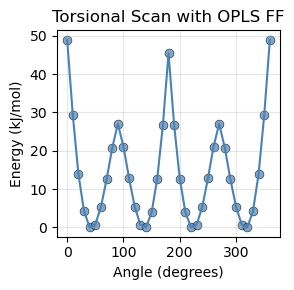

In [5]:
#assign mixing rules as lorentz-berthelot for now, since I don't understand openmm

df_opls = scan_dihedral_openmm(
    interchange=interchange_opls,
    dih_smarts = "[#6X3;r6:1]:[#6D3;r6:2]-[#6D3;r6:3]:[#6X3;r6:4]",
    angles_deg=range(0, 361, 10),   # or list(...)
    k_restraint=10000.0,             # kJ/mol/rad^2 (default OK)
    xyz_path="opls_scan.xyz",  # save xyz file for visualization (optional, can be empty string)
    combine_nonbonded_forces=False
)

""" 
This is still combining the nonbonded forces--just not in openmm. Source: openff developers on slack, it just
doesn't handle it in openmm and instead constructs them in the interchange object.

"""

plt.figure(figsize=(3,3))
# Plot the line
plt.plot(df_opls["angle"], df_opls["energy_kJ_mol"]-df_opls["energy_kJ_mol"].min(), color="#4982B6", linestyle='-',label="OPLS FF")
# Add scatter points on top
plt.scatter(df_opls["angle"], df_opls["energy_kJ_mol"]-df_opls["energy_kJ_mol"].min(), color="#4982B6", s=40, edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Angle (degrees)")
plt.ylabel("Energy (kJ/mol)")
plt.title("Torsional Scan with OPLS FF")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Ok, so some qualitative similarities but definitely not the same. Let's use xtb to investigate which one is closer to the truth, then adjust the parameters of openFF to match our 'ground truth' calculations.

xtb Dihedral scan: 100%|██████████| 37/37 [00:36<00:00,  1.01it/s]


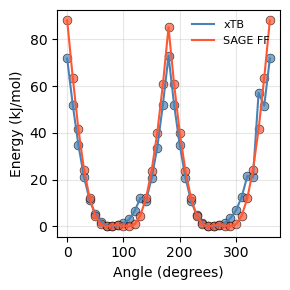

In [6]:
# --- inputs ---
from helpers import scan_dihedral_xtb


df_xtb = scan_dihedral_xtb(
    smi=smi,
    angles_deg=range(0, 361, 10),   # or list(...)
    dih_smarts=dih_smarts,
    method="GFN2-xTB",  # or "GFN0-xTB", "GFNFF", etc.
)


rel = lambda df: df["energy_kJ_mol"] - df["energy_kJ_mol"].min()

plt.figure(figsize=(3,3))

# xTB
plt.plot(df_xtb["angle"],  rel(df_xtb),  '-', color="#4982B6", label="xTB")
plt.scatter(df_xtb["angle"], rel(df_xtb), s=40, edgecolor='black', linewidth=0.5,
            alpha=0.7, color="#4982B6")

# SAGE
plt.plot(df_sage["angle"], rel(df_sage), '-', color="#FF5733", label="SAGE FF")
plt.scatter(df_sage["angle"], rel(df_sage), s=40, edgecolor='black', linewidth=0.5,
            alpha=0.7, color="#FF5733")

plt.xlabel("Angle (degrees)")
plt.ylabel("Energy (kJ/mol)")
plt.legend(fontsize=8, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




I've also added a psi4 scanner to helpers.py if you want to run B3LYP on this to get more accurate energies, but for the purpose of this example we'll stick with semi empirical methods.


If we were doing this for a production quality molecule we would use the OpenFF 'bespokefit' software, which provides fragments, target bonds, and a workflow to optimize torsional parameters. [https://pubs.acs.org/doi/10.1021/acs.jcim.2c01153] The program itself can be finicky and is difficult to get working on Princeton's clusters, so for this demonstration, we will fit the relevant torsion to the xTB data and drop it in our ```.offxml``` file manually. 

We fit to this expression
$$U_{\text{torsions}}(\theta) \;=\; \sum_{i=1}^{4} k_i\!\left(1 + \cos\!\bigl(n_i \theta - \phi_i\bigr)\right)$$

Note that in our file, this is the input:

```<Proper smirks="[*:1]~[*:2]=[#6,#7,#16,#15;X2:3]=[*:4]" periodicity1="1" phase1="0.0 * degree ** 1" id="t167" k1="0.0 * mole ** -1 * kilocalorie ** 1" idivf1="1.0"></Proper>```

We will emulate that

<Proper smirks="[#6X3;r6:1]:[#6D3;r6:2]-[#6D3;r6:3]:[#6X3;r6:4]" periodicity1="1" phase1="159.4815 * degree" k1="-1.288321 * kilocalories_per_mole" idivf1="1.0" periodicity2="2" phase2="-5.8906 * degree" k2="5.927987 * kilocalories_per_mole" idivf2="1.0" periodicity3="3" phase3="111.3626 * degree" k3="-1.148793 * kilocalories_per_mole" idivf3="1.0" periodicity4="4" phase4="-0.7499 * degree" k4="2.057694 * kilocalories_per_mole" idivf4="1.0" periodicity5="5" phase5="72.4876 * degree" k5="-1.004425 * kilocalories_per_mole" idivf5="1.0" periodicity6="6" phase6="-2.3351 * degree" k6="0.621012 * kilocalories_per_mole" idivf6="1.0" id="t1_6_fit"/>


Text(0.5, 1.0, 'Torsional Scan with xTB')

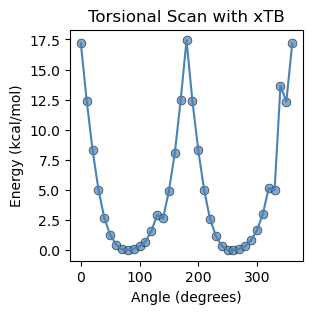

In [23]:
import numpy as np
from scipy.optimize import curve_fit


# --- Inputs ---

smirks=dih_smarts #in reality you should change this to make it more specific to your molecule


phi_rad = np.deg2rad(df_xtb["angle"].values)          # radians
E_kcal  = df_xtb["energy_kJ_mol"].values / 4.184      # → kcal/mol
E_kcal -= E_kcal.min()                                 # zero-baseline


def torsion6(phi,
             k1, phi1,
             k2, phi2,
             k3, phi3,
             k4, phi4,
             k5, phi5,
             k6, phi6):
    return (
        k1*(1 + np.cos(1*phi - phi1)) +
        k2*(1 + np.cos(2*phi - phi2)) +
        k3*(1 + np.cos(3*phi - phi3)) +
        k4*(1 + np.cos(4*phi - phi4)) +
        k5*(1 + np.cos(5*phi - phi5)) +
        k6*(1 + np.cos(6*phi - phi6))
    )

p0 = [1, 0]*6
params, _ = curve_fit(torsion6, phi_rad, E_kcal, p0=p0)
# unpack
k1, phi1, k2, phi2, k3, phi3, k4, phi4, k5, phi5, k6, phi6 = params

E_fit = torsion6(phi_rad, *params)


periods  = list(range(1,7))
ks       = [k1, k2, k3, k4, k5, k6]
phases_d = np.rad2deg([phi1, phi2, phi3, phi4, phi5, phi6])
idivfs   = [1.0]*6
param_id = "t1_6_fit"

xml = (
    f'<Proper smirks="{smirks}" '
    + " ".join(
        f'periodicity{n}="{n}" '
        f'phase{n}="{ph:.4f} * degree" '
        f'k{n}="{kn:.6f} * kilocalories_per_mole" '
        f'idivf{n}="{idf}"'
        for n, ph, kn, idf in zip(periods, phases_d, ks, idivfs)
    )
    + f' id="{param_id}"/>'
)

print(xml)

# now plot
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
# Plot the line
plt.plot(np.rad2deg(phi_rad), E_kcal, color="#4982B6", linestyle='-', label="xTB")
# Add scatter points on top
plt.scatter(np.rad2deg(phi_rad), E_kcal, color="#4982B6", s=40, edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Angle (degrees)")
plt.ylabel("Energy (kcal/mol)")
plt.title("Torsional Scan with xTB")

Copy and paste this into /forcefields/custom_sage.offxml--although I may have formatted wrong, so check that first. Realistically you'd want to make the torsion more specific so the force field can generalize and you could automate this, this is just for demonstration. Let's try rerunning the sage simulation and comparing with xtb. 